In [1]:
import sys
sys.path.insert(0, 'C:\\Users\\fl6344\\Desktop\\Baldea\\MHE_learning_dynamics\\DySMHO\\model')
sys.path.insert(0, 'C:\\Users\\fl6344\\Desktop\\Baldea\\MHE_learning_dynamics\\DySMHO\\data')

import model_2D
import utils
import VDP_data_generation
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt

In [16]:
x = ['ab','b','c']
x.remove('b')
x

['ab', 'c']



--------------------------- Smoothing data ---------------------------


Prev STD: 0.00177 - New STD: 0.00078 - Percent change: -56.12320
Prev STD: 0.00078 - New STD: 0.00074 - Percent change: -4.88965
Smoothing window size (dimension 1): 11 

Prev STD: 0.00245 - New STD: 0.00048 - Percent change: -80.51237
Prev STD: 0.00048 - New STD: 0.00030 - Percent change: -37.26474
Prev STD: 0.00030 - New STD: 0.00026 - Percent change: -13.59164
Prev STD: 0.00026 - New STD: 0.00024 - Percent change: -6.00952
Smoothing window size (dimension 2): 31 



--------------------------- Pre-processing 1: Dimension 1 ---------------------------
                       0              1
y0          0.000000e+00   0.000000e+00
y1          0.000000e+00   0.000000e+00
y0*y1       7.334242e-08   3.250449e-10
y0^2        4.318831e-01   1.686092e-05
y1^2        1.298288e-48   2.343982e-49
(y0^2)*y1  3.557669e-162  2.222759e-162
y0*(y1^2)   7.077176e-98   3.366284e-98
 y0^3       9.950372e-03   4.208513e-06
y0^4 

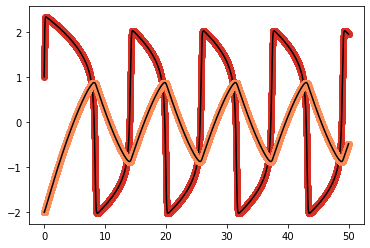

In [25]:
# Van der pol data 
y_init = [1, -2]

horizon_length = 20  # horizon length for optimization problem
time_steps = 30  # number of time steps taken in the MHE

# Basis functions
basis_functions_y0 = [lambda y0,y1: 1, 
                  lambda y0, y1: y0,
                  lambda y0, y1: y1, 
                  lambda y0, y1: y0*y1,
                  lambda y0, y1: y0**2,
                  lambda y0, y1: y1**2,
                  lambda y0, y1: (y0**2)*y1,
                  lambda y0, y1: y0*(y1**2),
                  lambda y0, y1: y0**3,
                  lambda y0, y1: y0**4,
                  lambda y0, y1: np.exp(y0), 
#                   lambda y0, y1: 1/y0, 
                  lambda y0, y1: np.sin(y0),
                  lambda y0, y1: np.cos(y0)]
basis_functions_y1 = [lambda y0,y1: 1, 
                  lambda y0, y1: y0,
                  lambda y0, y1: y1, 
                  lambda y0, y1: y0*y1,
                  lambda y0, y1: y0**2,
                  lambda y0, y1: y1**2,
                  lambda y0, y1: (y0**2)*y1,
                  lambda y0, y1: y0*(y1**2),
                  lambda y0, y1: y1**3,
                  lambda y0, y1: y1**4,
                  lambda y0, y1: np.exp(y1), 
#                   lambda y0, y1: 1/y1, 
                  lambda y0, y1: np.sin(y1),
                  lambda y0, y1: np.cos(y1)]
# Basis function names
basis_functions_names_y0 = ['1','y0', 'y1', 'y0*y1', 'y0^2', 'y1^2', '(y0^2)*y1', 'y0*(y1^2)', ' y0^3',  'y0^4', 'exp(y0)', 'sin(y0)', 'cos(y0)']
basis_functions_names_y1 = ['1','y0', 'y1', 'y0*y1', 'y0^2', 'y1^2', '(y0^2)*y1', 'y0*(y1^2)', ' y1^3',  'y1^4', 'exp(y1)', 'sin(y1)', 'cos(y1)']
basis_y0 = {'functions': basis_functions_y0, 'names': basis_functions_names_y0} 
basis_y1 = {'functions': basis_functions_y1, 'names': basis_functions_names_y1}


# Data generation (time grid)
xs = np.linspace(0, horizon_length + time_steps, 500 * (horizon_length + time_steps) + 1)
# Data generation (simulating true dynamics on the time grid with addition of white noise )
t, y = VDP_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0.005, 0, 0.005], False)
# Data generation (simulating true dynamics on the time grid without addition of white noise)
t_nf, y_nf = VDP_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0, 0, 0], False)

plt.plot(t,y)

reload(utils)
reload(model_2D)

# Creating MHL class
VDP_example = model_2D.DySMHO(y,t, [basis_y0, basis_y1])
VDP_example.smooth()
VDP_example.pre_processing_1(rm_features = [['1/y0'],['1/y1']])
VDP_example.pre_processing_2(significance = 0.8)
VDP_example.discover(horizon_length, 
                    time_steps, 
                    data_step = 50, 
                    optim_options = {'nfe': 80, 'ncp':15}, 
                    thresholding_frequency = 10, 
                    thresholding_tolerance = 1)
VDP_example.validate(xs, y_nf, plot = True)

